# Быстрое распознавание текста блоков диаграммы (Qwen2.5‑VL, без OCR)

Выход: очищенный список действий (по строкам). Основная логика распознавания сохранена: tiling → top‑K → батч‑генерация → дедуп/фильтрация.


In [ ]:
# # 0) Полная чистка
# !pip -q uninstall -y transformers tokenizers accelerate safetensors pillow bitsandbytes

# # 1) Pillow фиксируем (чтобы не ловить прошлый PIL/_typing)
# !pip -q install --no-cache-dir "Pillow==10.4.0"

# # 2) Ставим стабильный transformers, где есть AutoModelForVision2Seq в top-level импорте
# !pip -q install --no-cache-dir \
#   "transformers==4.55.3" "accelerate>=0.33.0" "tokenizers" "safetensors" "einops"

# # 3) 4-bit (опционально, если CUDA/GPU)
# !pip -q install --no-cache-dir "bitsandbytes>=0.43.0"



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 92.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
diffusers 0.36.0 requires safetensors>=0.3.1, which is not installed.
timm 1.0.24 requires safetensors, which is not installed.
torchtune 0.6.1 requires safetensors, which is not installed.
torchtune 0.6.1 requires tokenizers, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 144.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 197.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 294.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.2/507.2 kB 438.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 170.9 MB/s eta 0:00:00


In [1]:
import os, re, time
from typing import Dict, Any, List

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq


c:\Users\alike\MLSD\diagram2text\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_ID = os.environ.get("QWEN25_VL_MODEL_ID", "Qwen/Qwen2.5-VL-3B-Instruct")

def load_qwen25_vl(model_id: str = MODEL_ID):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

    common_kwargs = dict(
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        device_map="auto" if device == "cuda" else None,
    )

    if device == "cuda":
        try:
            from transformers import BitsAndBytesConfig
            bnb = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=(torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16),
            )
            model = AutoModelForVision2Seq.from_pretrained(model_id, quantization_config=bnb, **common_kwargs)
            model.eval()
            print("[ok] Loaded in 4-bit on CUDA")
            return processor, model
        except Exception as e:
            print("[warn] 4-bit не включился, загружаю без квантизации:", type(e).__name__, e)

    model = AutoModelForVision2Seq.from_pretrained(model_id, **common_kwargs)
    model.eval()
    print(f"[ok] Loaded without 4-bit on {device}")
    return processor, model

processor, model = load_qwen25_vl()


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.
c:\Users\alike\MLSD\diagram2text\.venv\Lib\site-packages\transformers\models\auto\modeling_auto.py:2199: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
Loading checkpoint shar

[ok] Loaded in 4-bit on CUDA


In [3]:
TEXT_ONLY_PROMPT_RU = """На изображении диаграмма (BPMN или блок-схема).

Выведи ТОЛЬКО текст, который ВИЗУАЛЬНО написан внутри блоков (прямоугольники/квадраты/ромбы/овалы/треугольники), по одной фразе на строку.
Правила:
- Не добавляй ничего от себя.
- Не выводи system/user/assistant и не повторяй инструкции.
- Если текста нет — верни пустую строку.
""".strip()


_RE_ROLE_PREFIX = re.compile(r"^(system|assistant|user)\s*[:\-]\s*", flags=re.IGNORECASE)
_RE_WS = re.compile(r"\s+")
_RE_YESNO = re.compile(r"^(да|нет)$", flags=re.IGNORECASE)

_BAD_LINE_PATTERNS = [
    re.compile(r"^на изображении\b.*", flags=re.IGNORECASE),
    re.compile(r"^выведи\b.*", flags=re.IGNORECASE),
    re.compile(r"^вывести\b.*", flags=re.IGNORECASE),
    re.compile(r"^правила\b.*", flags=re.IGNORECASE),
    re.compile(r"^-+\s*не\b.*", flags=re.IGNORECASE),
    re.compile(r"^-+\s*выводи\b.*", flags=re.IGNORECASE),
    re.compile(r"^-+\s*кажд\w*\b.*", flags=re.IGNORECASE),
    re.compile(r"^-+\s*не добавляй\b.*", flags=re.IGNORECASE),
    re.compile(r"^\.\s*$"),
]

def clean_vlm_output(model_text: str, prompt: str = "", drop_questions: bool = False) -> str:
    t = (model_text or "").strip()
    if not t:
        return ""

    if "assistant" in t:
        t = t.split("assistant")[-1].strip()

    p = (prompt or "").strip()
    if p and p in t:
        t = t.replace(p, "").strip()

    raw_lines = [ln.strip() for ln in t.splitlines() if ln.strip()]
    out_lines, seen = [], set()

    for ln in raw_lines:
        low = ln.lower().strip()
        if low in ("system", "user", "assistant"):
            continue

        ln = _RE_ROLE_PREFIX.sub("", ln).strip()
        ln = ln.replace("\u200b", "").strip()
        if not ln:
            continue

        low = ln.lower().strip()
        if any(rgx.match(low) for rgx in _BAD_LINE_PATTERNS):
            continue
        if _RE_YESNO.fullmatch(low):
            continue
        if drop_questions and ln.endswith("?"):
            continue

        ln = _RE_WS.sub(" ", ln).strip()
        key = ln.lower()
        if not key or key in seen:
            continue
        seen.add(key)
        out_lines.append(ln)

    return "\n".join(out_lines).strip()


In [4]:
def build_messages_for_image(image: Image.Image, prompt: str):
    return [
        {"role": "user", "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": prompt},
        ]}
    ]

def _resize_for_vlm(img: Image.Image, max_side: int = 768) -> Image.Image:
    w, h = img.size
    m = max(w, h)
    if m <= max_side:
        return img
    scale = max_side / m
    return img.resize((int(w*scale), int(h*scale)), Image.BICUBIC)


In [5]:
from PIL import ImageStat

def content_score(tile_img: Image.Image) -> float:
    gray = tile_img.convert("L").resize((256, 256), Image.BILINEAR)
    hist = gray.histogram()
    nonwhite = sum(hist[:240])
    total = sum(hist)
    return nonwhite / max(1, total)


def make_tiles(img: Image.Image, tile_w: int = 1024, tile_h: int = 1024, overlap: int = 128):
    W, H = img.size
    step_x = max(1, tile_w - overlap)
    step_y = max(1, tile_h - overlap)
    tiles = []
    y0 = 0
    while True:
        x0 = 0
        y1 = min(H, y0 + tile_h)
        while True:
            x1 = min(W, x0 + tile_w)
            tiles.append((x0, y0, x1, y1))
            if x1 == W:
                break
            x0 += step_x
        if y1 == H:
            break
        y0 += step_y
    return tiles

def select_topk_tiles(tiles, img: Image.Image, k: int = 4, min_score: float = 0.01):
    scored = []
    for box in tiles:
        crop = img.crop(box)
        s = content_score(crop)
        if s >= min_score:
            scored.append((s, box))
    scored.sort(key=lambda x: x[0], reverse=True)
    return [t for _, t in scored[:k]]

def crop_pil(img: Image.Image, box):
    return img.crop(box)


In [6]:
def filter_tasks(lines: List[str]) -> List[str]:
    banned_exact = { "система", "старт", "конец"}
    out = []
    for l in lines:
        ll = l.strip().lower()
        if not ll:
            continue
        if ll in banned_exact:
            continue
        if re.fullmatch(r"(да|нет)", ll):
            continue
        if len(ll) <= 18 and re.search(r"\b(есть|к оплате|успешно|место)\b", ll):
            continue
        out.append(l.strip())

    seen, final = set(), []
    for l in out:
        key = re.sub(r"\s+", " ", l).strip().lower()
        if key and key not in seen:
            seen.add(key)
            final.append(re.sub(r"\s+", " ", l).strip())
    return final

_ORDER_HINTS = ["выбор", "проверка", "подтвержден", "обработка", "создание", "получить", ]

def sort_tasks_semantic(lines: List[str]) -> List[str]:
    def score(line: str):
        ll = line.lower()
        for i, k in enumerate(_ORDER_HINTS):
            if k in ll:
                return i
        return 999
    return sorted(lines, key=score)


In [7]:
def analyze_diagram(
    image_path: str,
    tile_w: int = 1024,
    tile_h: int = 1024,
    overlap: int = 128,
    top_k_tiles: int = 4,
    max_new_tokens: int = 128,
    batch_size: int = 4,
) -> Dict[str, Any]:
    img = Image.open(image_path).convert("RGB")
    W, H = img.size
    t0 = time.time()

    do_tiling = (max(W, H) >= 1600) or (W / max(H, 1) >= 1.4)
    text_parts: List[str] = []
    # early stopping
    min_batches_before_stop = 2
    min_gain_to_continue = 2
    patience = 1

    def _norm_key(s: str) -> str:
        return re.sub(r"\s+", " ", s).strip().lower()

    seen_keys: set = set()
    low_gain_streak = 0
    batches_done = 0

    if do_tiling:
        tiles = make_tiles(img, tile_w=tile_w, tile_h=tile_h, overlap=overlap)
        top_tiles = select_topk_tiles(tiles, img, k=top_k_tiles, min_score=0.01)
        crops = [crop_pil(img, t) for t in top_tiles]

        # идём чанками по batch_size и останавливаемся, если новых строк почти не появляется
        for i in range(0, len(crops), batch_size):
            chunk = crops[i : i + batch_size]

            outs = vlm_generate_text_batch(
                chunk,                       # список картинок
                TEXT_ONLY_PROMPT_RU,
                max_new_tokens=max_new_tokens,
                batch_size=batch_size,        # внутри тоже чанкует, но chunk уже нужного размера
                clear_cache=False,
                max_side=600,
            )

            if isinstance(outs, str):
                outs = [outs]

            for txt in outs:
                if txt:
                    text_parts.append(txt)

            # --- early stop check: считаем прирост уникальных строк только по новому чанку ---
            gain = 0
            for txt in outs:
                if not txt:
                    continue
                for ln in txt.split("\n"):
                    ln = ln.strip()
                    if not ln:
                        continue
                    key = _norm_key(ln)
                    if key and key not in seen_keys:
                        seen_keys.add(key)
                        gain += 1

            batches_done += 1
            if batches_done >= min_batches_before_stop:
                if gain < min_gain_to_continue:
                    low_gain_streak += 1
                else:
                    low_gain_streak = 0

                if low_gain_streak >= patience:
                    break

    else:
        txt = vlm_generate_text_batch(
            img,
            TEXT_ONLY_PROMPT_RU,
            max_new_tokens=max_new_tokens,
            batch_size=1,
            clear_cache=False,
            max_side=1024,
        )
        if txt:
            text_parts.append(txt)


    text_parts = [clean_vlm_output(p, TEXT_ONLY_PROMPT_RU) for p in text_parts if p]

    lines, seen = [], set()
    for part in text_parts:
        for ln in [x.strip() for x in part.split("\n")]:
            if not ln:
                continue
            key = _norm_key(ln)
            if key and key not in seen:
                seen.add(key)
                lines.append(ln)

    lines = filter_tasks(lines)
    lines = sort_tasks_semantic(lines)
    raw_text = "\n".join(lines).strip()

    return {
        "raw_text": raw_text,
        "meta": {
            "image_path": image_path,
            "image_size": [W, H],
            "time_sec": round(time.time() - t0, 3),
            "device": "cuda" if torch.cuda.is_available() else "cpu",
            "model": MODEL_ID,
            "mode": "raw_text",
            "early_stop": {
                "batches_done": batches_done,
                "min_batches_before_stop": min_batches_before_stop,
                "min_gain_to_continue": min_gain_to_continue,
                "patience": patience,
            },
        },
    }


In [8]:
@torch.inference_mode()
def vlm_generate_text_batch(
    images,
    prompt: str,
    max_new_tokens: int = 128,
    batch_size: int = 4,
    clear_cache: bool = False,
    max_side: int = 768,
):
    single_input = False
    if isinstance(images, Image.Image):
        images = [images]
        single_input = True
    elif not isinstance(images, (list, tuple)):
        raise TypeError(f"`images` must be PIL.Image.Image or list/tuple, got: {type(images)}")

    images = [_resize_for_vlm(im, max_side=max_side) for im in list(images)]
    if len(images) == 0:
        return "" if single_input else []

    batch_size = max(1, int(batch_size) if batch_size else 1)
    all_outs: List[str] = []

    cached_chat = processor.apply_chat_template(
        build_messages_for_image(images[0], prompt),
        tokenize=False,
        add_generation_prompt=True
    )

    for i in range(0, len(images), batch_size):
        chunk = images[i:i+batch_size]

        texts = [cached_chat] * len(chunk)

        inputs = processor(text=texts, images=chunk, padding=True, return_tensors="pt")
        if torch.cuda.is_available():
            for k, v in list(inputs.items()):
                if torch.is_tensor(v):
                    inputs[k] = v.to("cuda", non_blocking=True)

        gen = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            num_beams=1,
            use_cache=True,
            eos_token_id=processor.tokenizer.eos_token_id,
        )

        outs = processor.batch_decode(gen, skip_special_tokens=True)
        all_outs.extend(outs)

        if clear_cache and torch.cuda.is_available():
            torch.cuda.empty_cache()

    return all_outs[0] if single_input else all_outs


In [10]:
from PIL import Image

def choose_top_k_tiles(
    img_path: str,
    *,
    base_side: int = 1400,   # размер, после которого обычно включается тайлинг
    base_k: int = 4,         # сколько тайлов хотим для "базовой" большой картинки
    k_min: int = 2,
    k_max: int = 12,
) -> int:
    """
    top_k зависит от:
      - площади (чем больше картинка, тем больше тайлов)
      - вытянутости (очень широкие/высокие диаграммы требуют больше тайлов)
    """
    w, h = Image.open(img_path).size
    area = w * h

    base_area = base_side * base_side  # условная "большая" картинка
    # масштаб по площади: sqrt(area/base_area) — более мягко растёт, чем линейно
    scale = (area / base_area) ** 0.5
    k = int(round(base_k * scale))

    # поправка на вытянутость
    aspect = max(w / h, h / w)  # >= 1
    if aspect >= 2.0:
        k += 2
    if aspect >= 3.0:
        k += 2

    return max(k_min, min(k_max, k))


SAMPLE_IMG = "data2\\test\\65.png"

top_k = choose_top_k_tiles(SAMPLE_IMG)
res = analyze_diagram(
    SAMPLE_IMG,
    top_k_tiles=top_k,
    max_new_tokens=64,
    batch_size=4,
)

print("chosen top_k_tiles:", top_k)
print("meta:", res["meta"])
print("\n--- RAW TEXT ---\n")
print(res["raw_text"])


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


chosen top_k_tiles: 5
meta: {'image_path': 'data2\\test\\65.png', 'image_size': [1678, 566], 'time_sec': 9.031, 'device': 'cuda', 'model': 'Qwen/Qwen2.5-VL-3B-Instruct', 'mode': 'raw_text', 'early_stop': {'batches_done': 1, 'min_batches_before_stop': 2, 'min_gain_to_continue': 2, 'patience': 1}}

--- RAW TEXT ---

М
Tools
PSC и
другое ПО


In [11]:
SAMPLE_IMG = "data2\\test\\135.png"

top_k = choose_top_k_tiles(SAMPLE_IMG)
res = analyze_diagram(
    SAMPLE_IMG,
    top_k_tiles=top_k,
    max_new_tokens=64,
    batch_size=4,
)

print("chosen top_k_tiles:", top_k)
print("meta:", res["meta"])
print("\n--- RAW TEXT ---\n")
print(res["raw_text"])

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


chosen top_k_tiles: 4
meta: {'image_path': 'data2\\test\\135.png', 'image_size': [580, 1278], 'time_sec': 9.354, 'device': 'cuda', 'model': 'Qwen/Qwen2.5-VL-3B-Instruct', 'mode': 'raw_text', 'early_stop': {'batches_done': 0, 'min_batches_before_stop': 2, 'min_gain_to_continue': 2, 'patience': 1}}

--- RAW TEXT ---

Конфликт/несогласие
Попытка переговоров
Неудача
Обращение к медиатору/арбитру
Арбитражный процесс
Решение арбитра
Расторгнуть
Оформление раст


In [12]:
SAMPLE_IMG = "data2/test/72.png"

top_k = choose_top_k_tiles(SAMPLE_IMG)
res = analyze_diagram(
    SAMPLE_IMG,
    top_k_tiles=top_k,
    max_new_tokens=64,
    batch_size=4,
)

print("chosen top_k_tiles:", top_k)
print("meta:", res["meta"])
print("\n--- RAW TEXT ---\n")
print(res["raw_text"])

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


chosen top_k_tiles: 3
meta: {'image_path': 'data2/test/72.png', 'image_size': [816, 1288], 'time_sec': 10.293, 'device': 'cuda', 'model': 'Qwen/Qwen2.5-VL-3B-Instruct', 'mode': 'raw_text', 'early_stop': {'batches_done': 0, 'min_batches_before_stop': 2, 'min_gain_to_continue': 2, 'patience': 1}}

--- RAW TEXT ---

Начало
Наполнить чайник
Включить чайник
Ждать закипания
Событие: Чайник закипел
Таймер: 30 сек
Действие: Выключить вручную
Автовыключение
Чай


In [14]:
SAMPLE_IMG = "data2/Picture/68.png"

top_k = choose_top_k_tiles(SAMPLE_IMG)
res = analyze_diagram(
    SAMPLE_IMG,
    top_k_tiles=top_k,
    max_new_tokens=64,
    batch_size=4,
)

print("chosen top_k_tiles:", top_k)
print("meta:", res["meta"])
print("\n--- RAW TEXT ---\n")
print(res["raw_text"])

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


chosen top_k_tiles: 4
meta: {'image_path': 'data2/Picture/68.png', 'image_size': [436, 1298], 'time_sec': 8.471, 'device': 'cuda', 'model': 'Qwen/Qwen2.5-VL-3B-Instruct', 'mode': 'raw_text', 'early_stop': {'batches_done': 0, 'min_batches_before_stop': 2, 'min_gain_to_continue': 2, 'patience': 1}}

--- RAW TEXT ---

Начало
Чайник пуст?
Слить старую воду
Наполнить свежей водой
Включить чайник
Ждать
Чайник закипел
Подготовить чашки
Положить чай в зав


In [15]:
import re

def action_to_md_rows_keep_linebreaks(text: str):

    if text is None:
        return []
    lines = [ln.strip() for ln in str(text).splitlines()]
    rows = []
    for ln in lines:
        if not ln:
            continue
        ln = ln.replace("|", "\\|")  # чтобы не ломать markdown
        rows.append(f"| {ln} |")
    return rows

def raw_text_to_md_table(raw_text: str) -> str:

    header = ["| Действие |", "|---|"]
    rows = action_to_md_rows_keep_linebreaks(raw_text)
    return "\n".join(header + rows)


In [17]:
md = raw_text_to_md_table(res["raw_text"])
print(md)


| Действие |
|---|
| Начало |
| Чайник пуст? |
| Слить старую воду |
| Наполнить свежей водой |
| Включить чайник |
| Ждать |
| Чайник закипел |
| Подготовить чашки |
| Положить чай в зав |


# Оценка результатов

In [18]:
JUDGE_PROMPT_RU = """Ты — строгий судья качества распознавания текста на диаграммах.

Тебе дано:
1) изображение диаграммы
2) распознанный результат (список строк)

Оцени качество распознавания ТОЛЬКО по изображению.

Правила:
- Сравни распознанные строки с реально видимыми надписями ВНУТРИ блоков действий (прямоугольники/овалы/ромбы/и т.п.).
- Игнорируй надписи на стрелках, условия ("Да/Нет"), "Старт/Конец", заголовки, роли, подписи дорожек, служебные слова.
- Штрафуй галлюцинации: строки, которых нет на картинке.
- Штрафуй утечки промпта/служебного текста.

Верни ТОЛЬКО JSON в таком формате:
{
  "text_coverage": 0-100,
  "text_accuracy": 0-100,
  "order_quality": 0-100,
  "hallucinations": 0-100,
  "overall": 0-100,
  "missing_examples": ["пример реально видимого текста, которого нет в выводе (до 3)"],
  "hallucinated_examples": ["пример строки из вывода, которой нет на изображении (до 3)"],
  "notes": "1-2 коротких предложения"
}
"""


In [19]:
import json, re
from PIL import Image
import torch

def _extract_first_json(text: str) -> str:
    t = re.sub(r"```(?:json)?", "", text, flags=re.IGNORECASE).replace("```", "").strip()
    start = t.find("{")
    if start < 0:
        raise ValueError("No JSON object found")
    depth = 0
    for i in range(start, len(t)):
        c = t[i]
        if c == "{":
            depth += 1
        elif c == "}":
            depth -= 1
            if depth == 0:
                return t[start:i+1]
    raise ValueError("Unbalanced JSON braces")


In [20]:
@torch.inference_mode()
def judge_recognition_quality(
    image: Image.Image,
    raw_text: str,
    max_new_tokens: int = 256,
) -> dict:
    """
    LLM-as-a-judge: оценивает качество распознавания.
    Использует уже загруженные `processor` и `model` (Qwen2.5-VL).
    """
    if isinstance(image, str):
        image = Image.open(image).convert("RGB")

    try:
        image_j = _resize_for_vlm(image, max_side=1024)
    except Exception:
        image_j = image

    user_text = "Распознанный результат (каждая строка — отдельный блок):\n" + (raw_text or "").strip()

    messages = [
        {"role": "system", "content": "Ты внимательный и строгий оценщик качества распознавания диаграмм."},
        {"role": "user", "content": [
            {"type": "image", "image": image_j},
            {"type": "text",  "text": JUDGE_PROMPT_RU + "\n\n" + user_text}
        ]}
    ]

    chat = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[chat], images=[image_j], padding=True, return_tensors="pt")

    if torch.cuda.is_available():
        for k, v in list(inputs.items()):
            if torch.is_tensor(v):
                inputs[k] = v.to(model.device)

    gen = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        num_beams=1,
        use_cache=True,
        eos_token_id=processor.tokenizer.eos_token_id,
    )
    out = processor.batch_decode(gen, skip_special_tokens=True)[0]

    js = _extract_first_json(out)
    return json.loads(js)


In [21]:
import re

HOMOGLYPHS = {
    'A': 'А', 'B': 'В', 'C': 'С', 'E': 'Е', 'H': 'Н',
    'K': 'К', 'M': 'М', 'O': 'О', 'P': 'Р', 'T': 'Т',
    'X': 'Х', 'a': 'а', 'c': 'с', 'e': 'е', 'o': 'о',
    'p': 'р', 'x': 'х', 'y': 'у', '3': 'З', '0': 'О',
}

_ALNUM_RE = re.compile(r"[A-Za-zА-Яа-яЁё0-9]")

def homoglyphs_score(text: str) -> int:
    """
    100 = нет гомоглифов
    0 = все символы (из учитываемых) — гомоглифы из HOMOGLYPHS
    """
    if not text:
        return 100

    total = 0
    bad = 0
    for ch in text:
        if not _ALNUM_RE.match(ch):
            continue
        total += 1
        if ch in HOMOGLYPHS:
            bad += 1

    if total == 0:
        return 100

    score = round(100 * (1 - bad / total))
    return max(0, min(100, int(score)))


In [22]:
import re
from PIL import Image
import torch

JUDGE_PROMPT_FMT_RU = """Ты — строгий судья качества распознавания текста на диаграммах.

Оцени по изображению и распознанному результату.

Игнорируй: надписи на стрелках, условия "Да/Нет", "Старт/Конец", заголовки, роли/дорожки, служебный текст.

Верни ответ СТРОГО в формате 9 строк:

COVERAGE: <0-100>
ACCURACY: <0-100>
ORDER: <0-100>
HOMOGLYPHS: 0           (НЕ оценивай это поле, оставь 0)
OVERALL: <0-100>
MISSING1: <пример текста, который есть на изображении, но отсутствует в выводе или пусто>
MISSING2: <... или пусто>
HALLUC1: <пример строки из вывода, которой нет на изображении или пусто>
NOTES: <1 короткое предложение>

Никаких других строк. Никаких списков. Никаких JSON.
"""


import re
from PIL import Image
import torch

@torch.inference_mode()
def judge_recognition_quality(image, raw_text: str, max_new_tokens: int = 200) -> dict:
    if isinstance(image, str):
        image = Image.open(image).convert("RGB")

    # чуть уменьшим для скорости
    try:
        image_j = _resize_for_vlm(image, max_side=1024)
    except Exception:
        image_j = image

    prompt_text = (
        JUDGE_PROMPT_FMT_RU
        + "\n\nРаспознанный результат (каждая строка — блок):\n"
        + (raw_text or "").strip()
    )

    messages = [
        {"role": "system", "content": "Ты отвечаешь строго по формату."},
        {"role": "user", "content": [
            {"type": "image", "image": image_j},
            {"type": "text", "text": prompt_text}
        ]}
    ]
    chat = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[chat], images=[image_j], padding=True, return_tensors="pt")

    if torch.cuda.is_available():
        for k, v in list(inputs.items()):
            if torch.is_tensor(v):
                inputs[k] = v.to(model.device)

    gen = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        num_beams=1,
        use_cache=True,
        eos_token_id=processor.tokenizer.eos_token_id,
    )
    out = processor.batch_decode(gen, skip_special_tokens=True)[0].strip()

    # --- парсер фикс-формата ---
    def _get_int(key: str, default=0):
        m = re.search(rf"^{key}:\s*(\d{{1,3}})\s*$", out, flags=re.MULTILINE)
        if not m:
            return default
        v = int(m.group(1))
        return max(0, min(100, v))

    def _get_str(key: str):
        m = re.search(rf"^{key}:\s*(.*)\s*$", out, flags=re.MULTILINE)
        return (m.group(1).strip() if m else "")

    # --- новая метрика ---
    hg = homoglyphs_score(raw_text or "")

    result = {
        "text_coverage": _get_int("COVERAGE", 0),
        "text_accuracy": _get_int("ACCURACY", 0),
        "order_quality": _get_int("ORDER", 0),

        # было: hallucinations (оценка судьи)
        # стало: homoglyphs по сырому распознанному тексту
        "homoglyphs": hg,

        "overall": _get_int("OVERALL", 0),
        "missing_examples": [x for x in [_get_str("MISSING1"), _get_str("MISSING2")] if x and x.lower() != "пусто"],
        "hallucinated_examples": [x for x in [_get_str("HALLUC1")] if x and x.lower() != "пусто"],
        "notes": _get_str("NOTES"),
        "raw_judge_output": out,
    }
    return result


In [23]:
def score_to_markdown(score: dict) -> str:
    def fmt(v):
        return "—" if v is None or v == "" else str(v)

    rows = [
        ("Text coverage", fmt(score.get("text_coverage"))),
        ("Text accuracy", fmt(score.get("text_accuracy"))),
        ("Order quality", fmt(score.get("order_quality"))),
        ("homoglyphs", fmt(score.get("homoglyphs"))),
        ("Overall", fmt(score.get("overall"))),
        ("Missing examples", "<br>".join(score.get("missing_examples", [])) or "—"),
("Generation time", fmt(res['meta']['time_sec'])),]

    md = ["| Metric | Score |", "|---|---|"]
    for k, v in rows:
        md.append(f"| {k} | {v} |")
    return "\n".join(md)


In [24]:


score = judge_recognition_quality(SAMPLE_IMG, res["raw_text"], max_new_tokens=256)
print(score)


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


{'text_coverage': 100, 'text_accuracy': 100, 'order_quality': 100, 'homoglyphs': 100, 'overall': 100, 'missing_examples': ['<пример текста, который есть на изображении, но отсутствует в выводе или пусто>', '<... или пусто>'], 'hallucinated_examples': ['<пример строки из вывода, которой нет на изображении или пусто>'], 'notes': '<1 короткое предложение>', 'raw_judge_output': 'system\nТы отвечаешь строго по формату.\nuser\nТы — строгий судья качества распознавания текста на диаграммах.\n\nОцени по изображению и распознанному результату.\n\nИгнорируй: надписи на стрелках, условия "Да/Нет", "Старт/Конец", заголовки, роли/дорожки, служебный текст.\n\nВерни ответ СТРОГО в формате 9 строк:\n\nCOVERAGE: <0-100>\nACCURACY: <0-100>\nORDER: <0-100>\nHOMOGLYPHS: 0           (НЕ оценивай это поле, оставь 0)\nOVERALL: <0-100>\nMISSING1: <пример текста, который есть на изображении, но отсутствует в выводе или пусто>\nMISSING2: <... или пусто>\nHALLUC1: <пример строки из вывода, которой нет на изображ

text_coverage: сколько “реальных” блоков из диаграммы попало в вывод (0–100)

text_accuracy: насколько точно переписан текст (ошибки букв/слов снижают)

order_quality: насколько корректен порядок (по стрелкам/визуально)

overall: итоговая оценка

In [25]:
md_table = score_to_markdown(score)
print(md_table)


| Metric | Score |
|---|---|
| Text coverage | 100 |
| Text accuracy | 100 |
| Order quality | 100 |
| homoglyphs | 100 |
| Overall | 100 |
| Missing examples | <пример текста, который есть на изображении, но отсутствует в выводе или пусто><br><... или пусто> |
| Generation time | 8.471 |


# algoritm to diagram

In [26]:
PROMPT_TEXT2DIAGRAM_MERMAID = """Ты — генератор диаграмм по текстовому алгоритму.

Вход: текст алгоритма (шаги на русском, могут быть условия, ветвления, циклы).
Выход: ТОЛЬКО код Mermaid.

Требования:
- Верни только блок mermaid без пояснений.
- Используй flowchart TD.
- Каждый шаг — отдельный узел.
- Если есть условие (вопрос/проверка/если/иначе) — используй ромб { } и подпиши выходы "Да"/"Нет".
- Если порядок явно задан (1., 2., 3. или "затем/после") — соблюдай его.
- Не выдумывай шагов: используй только то, что есть во входе.
- Если роли указаны (например "Пользователь:", "Система:"), добавляй их в текст узла как "Роль — Действие".
"""


In [28]:
import re
import math
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import torch
from PIL import Image as PILImage
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
from IPython.display import Image as IPyImage, display


# -----------------------------
# 1) Qwen: текст алгоритма -> Mermaid flowchart TD
# -----------------------------

PROMPT_TEXT2DIAGRAM_MERMAID = """Ты — генератор диаграмм по текстовому алгоритму.

Вход: текст алгоритма (шаги на русском, могут быть условия, ветвления, циклы).
Выход: ТОЛЬКО код Mermaid.

Требования:
- Верни только mermaid-код без пояснений.
- Формат: flowchart TD
- Каждый шаг — отдельный узел.
- Если есть условие (если/иначе/проверка/вопрос) — используй ромб { } и подпиши выходы "Да"/"Нет".
- Не выдумывай шагов: используй только то, что есть во входе.
- Узлы подписывай внутри [] или {} (для условия).
"""

@torch.inference_mode()
def qwen_generate_text(prompt: str, max_new_tokens: int = 700) -> str:
    messages = [
        {"role": "system", "content": "Ты отвечаешь строго в требуемом формате."},
        {"role": "user", "content": prompt},
    ]
    chat = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[chat], padding=True, return_tensors="pt")

    if torch.cuda.is_available():
        for k, v in list(inputs.items()):
            if torch.is_tensor(v):
                inputs[k] = v.to(model.device)

    gen = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        num_beams=1,
        use_cache=True,
        eos_token_id=processor.tokenizer.eos_token_id,
    )
    return processor.batch_decode(gen, skip_special_tokens=True)[0].strip()


def extract_mermaid_flowchart(text: str) -> str:
    # если модель вернула ```...```
    m = re.search(r"```(?:mermaid)?\s*(.*?)```", text, flags=re.DOTALL | re.IGNORECASE)
    if m:
        text = m.group(1).strip()

    # оставляем от первого "flowchart"
    m2 = re.search(r"(flowchart\s+TD[\s\S]*)", text, flags=re.IGNORECASE)
    if m2:
        text = m2.group(1).strip()

    # убираем дубли "flowchart TD" (частая проблема)
    parts = re.split(r"(?=flowchart\s+TD)", text, flags=re.IGNORECASE)
    if len(parts) > 1:
        # берём первый непустой блок
        for p in parts:
            p = p.strip()
            if p.lower().startswith("flowchart td"):
                text = p
                break

    return text.strip()


def algorithm_text_to_mermaid(algorithm_text: str, max_new_tokens: int = 700) -> str:
    prompt = PROMPT_TEXT2DIAGRAM_MERMAID + "\n\nАЛГОРИТМ:\n" + algorithm_text.strip()
    out = qwen_generate_text(prompt, max_new_tokens=max_new_tokens)
    return extract_mermaid_flowchart(out)


# -----------------------------
# 2) Парсер Mermaid flowchart TD -> граф
# -----------------------------

@dataclass
class Node:
    id: str
    label: str
    shape: str  # "rect" or "diamond"


@dataclass
class Edge:
    src: str
    dst: str
    label: str = ""  # "Да"/"Нет" или пусто


_NODE_RE = re.compile(
    r"""
    (?P<id>[A-Za-z][A-Za-z0-9_]*)
    (?:
        \[(?P<rect>[^\]]+)\]     |    # A[Text]
        \{(?P<diam>[^\}]+)\}     |    # A{Cond}
        \((?P<round>[^\)]+)\)         # A(Text) -> будем рисовать как rect
    )?
    """,
    re.VERBOSE,
)

_EDGE_RE = re.compile(
    r"""
    ^
    \s*(?P<lhs>.+?)\s*
    (?P<arrow>-->|---|-.+?->|==>|-->)
    \s*(?P<rhs>.+?)\s*$
    """,
    re.VERBOSE,
)

_EDGE_LABEL_RE = re.compile(r"--\s*(?P<label>[^-]+?)\s*-->")  # A -- Да --> B


def _parse_node(token: str) -> Tuple[str, Optional[str], str]:
    """
    token: "A[Text]" or "B{Cond}" or "C" (без подписи)
    returns: (id, label_or_None, shape)
    """
    token = token.strip()
    m = _NODE_RE.match(token)
    if not m:
        # fallback: берём всё как id
        return token, None, "rect"

    nid = m.group("id")
    if m.group("rect") is not None:
        return nid, m.group("rect").strip(), "rect"
    if m.group("diam") is not None:
        return nid, m.group("diam").strip(), "diamond"
    if m.group("round") is not None:
        return nid, m.group("round").strip(), "rect"
    return nid, None, "rect"


def parse_mermaid_flowchart(mermaid_code: str) -> Tuple[Dict[str, Node], List[Edge]]:
    lines = [ln.strip() for ln in mermaid_code.splitlines() if ln.strip()]
    # убираем "flowchart TD"
    if lines and lines[0].lower().startswith("flowchart"):
        lines = lines[1:]

    nodes: Dict[str, Node] = {}
    edges: List[Edge] = []

    for ln in lines:
        # поддержка comments
        if ln.startswith("%%"):
            continue

        m = _EDGE_RE.match(ln)
        if not m:
            continue

        lhs_raw = m.group("lhs").strip()
        rhs_raw = m.group("rhs").strip()

        # edge label внутри стрелки: A -- Да --> B
        edge_label = ""
        labm = _EDGE_LABEL_RE.search(ln)
        if labm:
            edge_label = labm.group("label").strip()

        src_id, src_label, src_shape = _parse_node(lhs_raw)
        dst_id, dst_label, dst_shape = _parse_node(rhs_raw)

        if src_id not in nodes:
            nodes[src_id] = Node(src_id, src_label or src_id, src_shape)
        else:
            if src_label and nodes[src_id].label == src_id:
                nodes[src_id].label = src_label
            if src_shape == "diamond":
                nodes[src_id].shape = "diamond"

        if dst_id not in nodes:
            nodes[dst_id] = Node(dst_id, dst_label or dst_id, dst_shape)
        else:
            if dst_label and nodes[dst_id].label == dst_id:
                nodes[dst_id].label = dst_label
            if dst_shape == "diamond":
                nodes[dst_id].shape = "diamond"

        edges.append(Edge(src_id, dst_id, edge_label))

    return nodes, edges


# -----------------------------
# 3) Лэйаут (TD) + рендер в PNG (матплотлиб)
# -----------------------------

def _topo_layout(nodes: Dict[str, Node], edges: List[Edge]) -> Dict[str, Tuple[float, float]]:
    """
    Простой TD layout:
    - rank = максимальная длина пути от источников
    - x = порядковый номер внутри rank
    """
    adj = {nid: [] for nid in nodes}
    indeg = {nid: 0 for nid in nodes}
    for e in edges:
        adj.setdefault(e.src, []).append(e.dst)
        indeg[e.dst] = indeg.get(e.dst, 0) + 1
        indeg.setdefault(e.src, indeg.get(e.src, 0))

    # Kahn topo
    queue = [nid for nid, d in indeg.items() if d == 0]
    # стабильность
    queue.sort()
    topo = []
    while queue:
        u = queue.pop(0)
        topo.append(u)
        for v in adj.get(u, []):
            indeg[v] -= 1
            if indeg[v] == 0:
                queue.append(v)
        queue.sort()

    # если цикл/что-то пошло не так — fallback: все узлы
    if len(topo) != len(nodes):
        topo = list(nodes.keys())

    # rank by longest path
    rank = {nid: 0 for nid in nodes}
    for u in topo:
        for v in adj.get(u, []):
            rank[v] = max(rank[v], rank[u] + 1)

    # group by rank
    by_rank: Dict[int, List[str]] = {}
    for nid, r in rank.items():
        by_rank.setdefault(r, []).append(nid)
    for r in by_rank:
        by_rank[r].sort()

    # positions
    pos = {}
    max_r = max(by_rank.keys()) if by_rank else 0
    for r in range(max_r + 1):
        layer = by_rank.get(r, [])
        for i, nid in enumerate(layer):
            pos[nid] = (i, -r)  # y вниз
    return pos


def render_flowchart_to_png(
    mermaid_code: str,
    out_path: str = "diagram.png",
    dpi: int = 180,
):
    nodes, edges = parse_mermaid_flowchart(mermaid_code)
    if not nodes:
        raise ValueError("Не удалось распарсить Mermaid-код (нет узлов).")

    pos = _topo_layout(nodes, edges)

    # размеры фигуры
    layers = {}
    for nid, (x, y) in pos.items():
        layers.setdefault(y, []).append(x)
    max_cols = max((len(set(xs)) for xs in layers.values()), default=1)
    max_rows = len(layers) if layers else 1

    fig_w = max(8, 2.2 * max_cols)
    fig_h = max(6, 1.6 * max_rows)

    fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=dpi)
    ax.set_axis_off()

    # параметры узлов
    box_w = 2.8
    box_h = 0.9
    x_gap = 0.8
    y_gap = 1.2

    # нормируем координаты
    xs = [p[0] for p in pos.values()]
    ys = [p[1] for p in pos.values()]
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)

    def to_plot(nid):
        x, y = pos[nid]
        px = (x - min_x) * (box_w + x_gap)
        py = (y - max_y) * (box_h + y_gap)  # чтобы сверху вниз
        return px, py

    # рисуем стрелки (сначала)
    for e in edges:
        if e.src not in nodes or e.dst not in nodes:
            continue
        x1, y1 = to_plot(e.src)
        x2, y2 = to_plot(e.dst)

        start = (x1 + box_w/2, y1 - box_h/2)
        end   = (x2 + box_w/2, y2 - box_h/2)

        arr = FancyArrowPatch(
            start, end,
            arrowstyle='->',
            mutation_scale=14,
            linewidth=1.5,
            connectionstyle="arc3,rad=0.0",
        )
        ax.add_patch(arr)

        if e.label:
            mx = (start[0] + end[0]) / 2
            my = (start[1] + end[1]) / 2
            ax.text(mx, my + 0.12, e.label, ha="center", va="bottom", fontsize=10)

    # рисуем узлы
    for nid, node in nodes.items():
        x, y = to_plot(nid)

        label = node.label.strip()
        # переносы строк для читаемости
        label = re.sub(r"\s+", " ", label)
        # грубое разбиение по длине
        if len(label) > 26:
            words = label.split()
            lines = []
            cur = []
            cur_len = 0
            for w in words:
                if cur_len + len(w) + (1 if cur else 0) <= 26:
                    cur.append(w); cur_len += len(w) + (1 if cur_len else 0)
                else:
                    lines.append(" ".join(cur))
                    cur = [w]
                    cur_len = len(w)
            if cur:
                lines.append(" ".join(cur))
            label = "\n".join(lines)

        if node.shape == "diamond":
            # ромб рисуем как повернутый квадрат: проще через FancyBboxPatch + rotation нет,
            # поэтому рисуем как bbox и помечаем (визуально близко) — для “картинка с блоками”
            patch = FancyBboxPatch(
                (x, y - box_h), box_w, box_h,
                boxstyle="round,pad=0.02,rounding_size=0.05",
                linewidth=1.6,
                facecolor="white",
            )
            ax.add_patch(patch)
            ax.text(x + box_w/2, y - box_h/2, label, ha="center", va="center", fontsize=10, fontweight="bold")
        else:
            patch = FancyBboxPatch(
                (x, y - box_h), box_w, box_h,
                boxstyle="round,pad=0.02,rounding_size=0.08",
                linewidth=1.6,
                facecolor="white",
            )
            ax.add_patch(patch)
            ax.text(x + box_w/2, y - box_h/2, label, ha="center", va="center", fontsize=10)

    # границы
    all_px = [to_plot(n)[0] for n in nodes]
    all_py = [to_plot(n)[1] for n in nodes]
    ax.set_xlim(min(all_px) - 1, max(all_px) + box_w + 1)
    ax.set_ylim(min(all_py) - box_h - 1, max(all_py) + 1)

    plt.tight_layout()
    fig.savefig(out_path, bbox_inches="tight")
    plt.close(fig)
    return out_path

def algorithm_text_to_diagram_png(
    algorithm_text: str,
    out_png: str = "diagram.png",
    qwen_max_new_tokens: int = 700,
):
    mermaid_code = algorithm_text_to_mermaid(algorithm_text, max_new_tokens=qwen_max_new_tokens)
    png_path = render_flowchart_to_png(mermaid_code, out_path=out_png)
    display(IPyImage(filename=png_path))
    return {"mermaid": mermaid_code, "png_path": png_path}


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


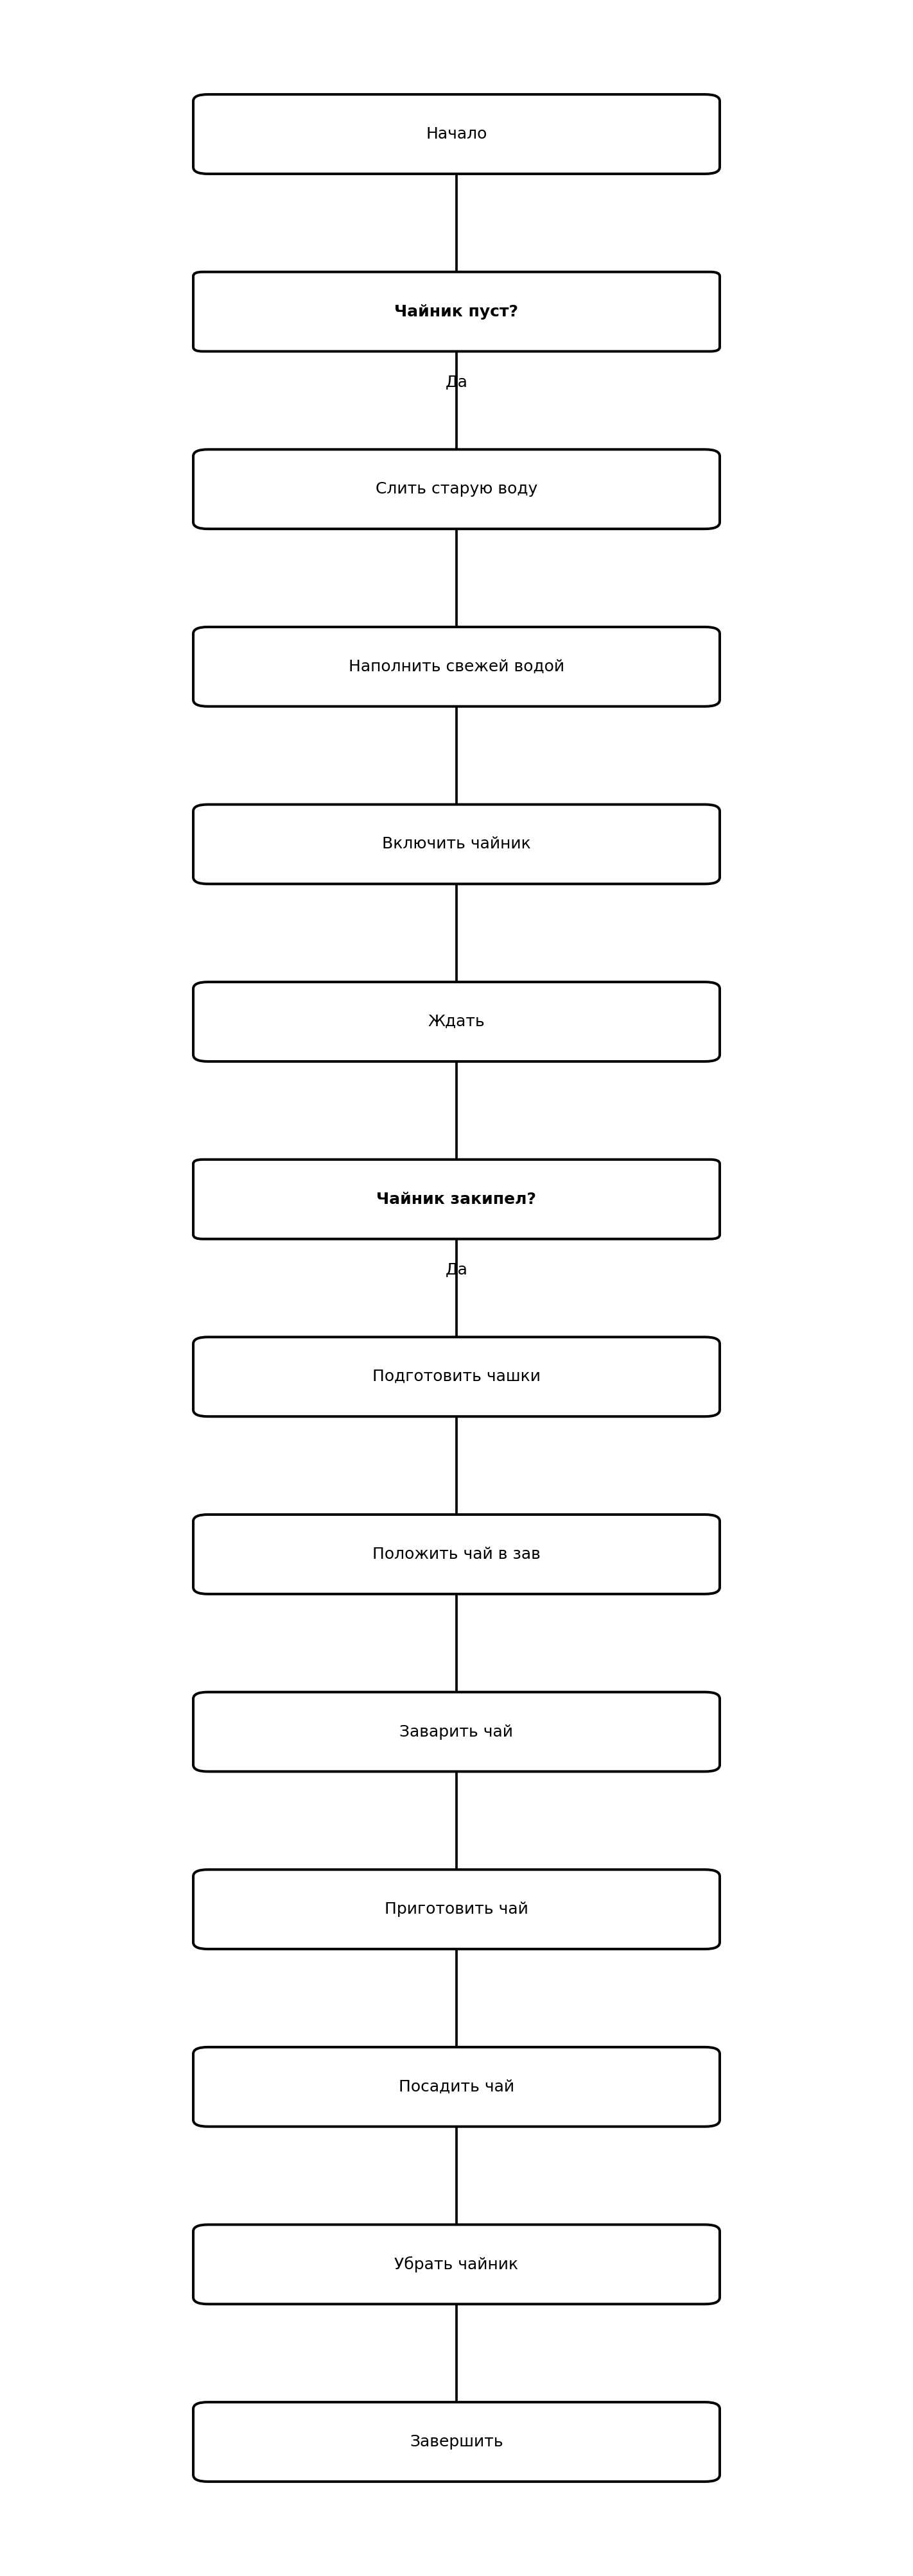

flowchart TD
    A[Начало] --> B{Чайник пуст?}
    B -- Да --> C[Слить старую воду]
    C --> D[Наполнить свежей водой]
    D --> E[Включить чайник]
    E --> F[Ждать]
    F --> G{Чайник закипел?}
    G -- Да --> H[Подготовить чашки]
    H --> I[Положить чай в зав]
    I --> J[Заварить чай]
    J --> K[Приготовить чай]
    K --> L[Посадить чай]
    L --> M[Убрать чайник]
    M --> N[Завершить]
Saved: algo_diagram.png


In [29]:

algo_text = res['raw_text']
res1 = algorithm_text_to_diagram_png(algo_text, out_png="algo_diagram.png")
print(res1["mermaid"])
print("Saved:", res1["png_path"])


# без llm

In [30]:
def algorithm_text_to_graph_simple(algorithm_text: str):
    lines = [ln.strip() for ln in algorithm_text.splitlines() if ln.strip()]
    nodes = {f"n{i+1}": Node(id=f"n{i+1}", label=lines[i], shape="rect") for i in range(len(lines))}
    edges = [Edge(src=f"n{i+1}", dst=f"n{i+2}", label="") for i in range(len(lines)-1)]
    return nodes, edges
import re
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch


def render_graph_to_png(
    nodes: Dict[str, "Node"],
    edges: List["Edge"],
    out_path: str = "diagram.png",
    dpi: int = 180,
):
    """
    Рендерит граф (nodes, edges) в PNG без Mermaid.

    Ожидаемые структуры:
      Node: {id: str, label: str, shape: str}  shape in {"rect","diamond"}
      Edge: {src: str, dst: str, label: str}

    Возвращает: out_path
    """
    if not nodes:
        raise ValueError("nodes пустой — нечего рисовать.")

    # --- layout (top-down) ---
    pos = _topo_layout(nodes, edges)  # использует твою существующую функцию

    # --- вычислим слои/размеры фигуры ---
    layers = {}
    for nid, (x, y) in pos.items():
        layers.setdefault(y, []).append(x)

    max_cols = max((len(sorted(set(xs))) for xs in layers.values()), default=1)
    max_rows = len(layers) if layers else 1

    fig_w = max(8, 2.2 * max_cols)
    fig_h = max(6, 1.6 * max_rows)

    fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=dpi)
    ax.set_axis_off()

    # --- параметры узлов ---
    box_w = 2.8
    box_h = 0.9
    x_gap = 0.8
    y_gap = 1.2

    xs = [p[0] for p in pos.values()]
    ys = [p[1] for p in pos.values()]
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)

    def to_plot(nid: str) -> Tuple[float, float]:
        x, y = pos[nid]
        px = (x - min_x) * (box_w + x_gap)
        py = (y - max_y) * (box_h + y_gap)  # сверху вниз
        return px, py

    # --- стрелки (сначала) ---
    for e in edges:
        if e.src not in nodes or e.dst not in nodes:
            continue
        if e.src not in pos or e.dst not in pos:
            continue

        x1, y1 = to_plot(e.src)
        x2, y2 = to_plot(e.dst)

        start = (x1 + box_w / 2, y1 - box_h / 2)
        end = (x2 + box_w / 2, y2 - box_h / 2)

        arr = FancyArrowPatch(
            start,
            end,
            arrowstyle="->",
            mutation_scale=14,
            linewidth=1.5,
            connectionstyle="arc3,rad=0.0",
        )
        ax.add_patch(arr)

        if getattr(e, "label", ""):
            mx = (start[0] + end[0]) / 2
            my = (start[1] + end[1]) / 2
            ax.text(mx, my + 0.12, e.label, ha="center", va="bottom", fontsize=10)

    # --- узлы ---
    for nid, node in nodes.items():
        if nid not in pos:
            continue
        x, y = to_plot(nid)

        label = (getattr(node, "label", nid) or nid).strip()
        label = re.sub(r"\s+", " ", label)

        # переносы строк для читаемости
        if len(label) > 26:
            words = label.split()
            lines, cur, cur_len = [], [], 0
            for w in words:
                add = len(w) + (1 if cur else 0)
                if cur_len + add <= 26:
                    cur.append(w)
                    cur_len += add
                else:
                    lines.append(" ".join(cur))
                    cur = [w]
                    cur_len = len(w)
            if cur:
                lines.append(" ".join(cur))
            label = "\n".join(lines)

        shape = getattr(node, "shape", "rect")

        # ромб: здесь рисуем как более "жёсткий" блок + жирный шрифт (просто и стабильно)
        if shape == "diamond":
            patch = FancyBboxPatch(
                (x, y - box_h),
                box_w,
                box_h,
                boxstyle="round,pad=0.02,rounding_size=0.05",
                linewidth=1.8,
                facecolor="white",
            )
            ax.add_patch(patch)
            ax.text(
                x + box_w / 2,
                y - box_h / 2,
                label,
                ha="center",
                va="center",
                fontsize=10,
                fontweight="bold",
            )
        else:
            patch = FancyBboxPatch(
                (x, y - box_h),
                box_w,
                box_h,
                boxstyle="round,pad=0.02,rounding_size=0.08",
                linewidth=1.6,
                facecolor="white",
            )
            ax.add_patch(patch)
            ax.text(x + box_w / 2, y - box_h / 2, label, ha="center", va="center", fontsize=10)

    # --- границы ---
    all_px = [to_plot(n)[0] for n in nodes if n in pos]
    all_py = [to_plot(n)[1] for n in nodes if n in pos]
    ax.set_xlim(min(all_px) - 1, max(all_px) + box_w + 1)
    ax.set_ylim(min(all_py) - box_h - 1, max(all_py) + 1)

    plt.tight_layout()
    fig.savefig(out_path, bbox_inches="tight")
    plt.close(fig)
    return out_path


In [31]:
def algorithm_text_to_diagram_png_no_llm(
    algorithm_text: str,
    out_png: str = "diagram.png",
):
    # строим граф напрямую
    nodes, edges = algorithm_text_to_graph_simple(algorithm_text)

    # рендер (чуть модифицируй render_flowchart_to_png, чтобы принимал nodes/edges)
    png_path = render_graph_to_png(nodes, edges, out_path=out_png)
    display(IPyImage(filename=png_path))
    return {"png_path": png_path}


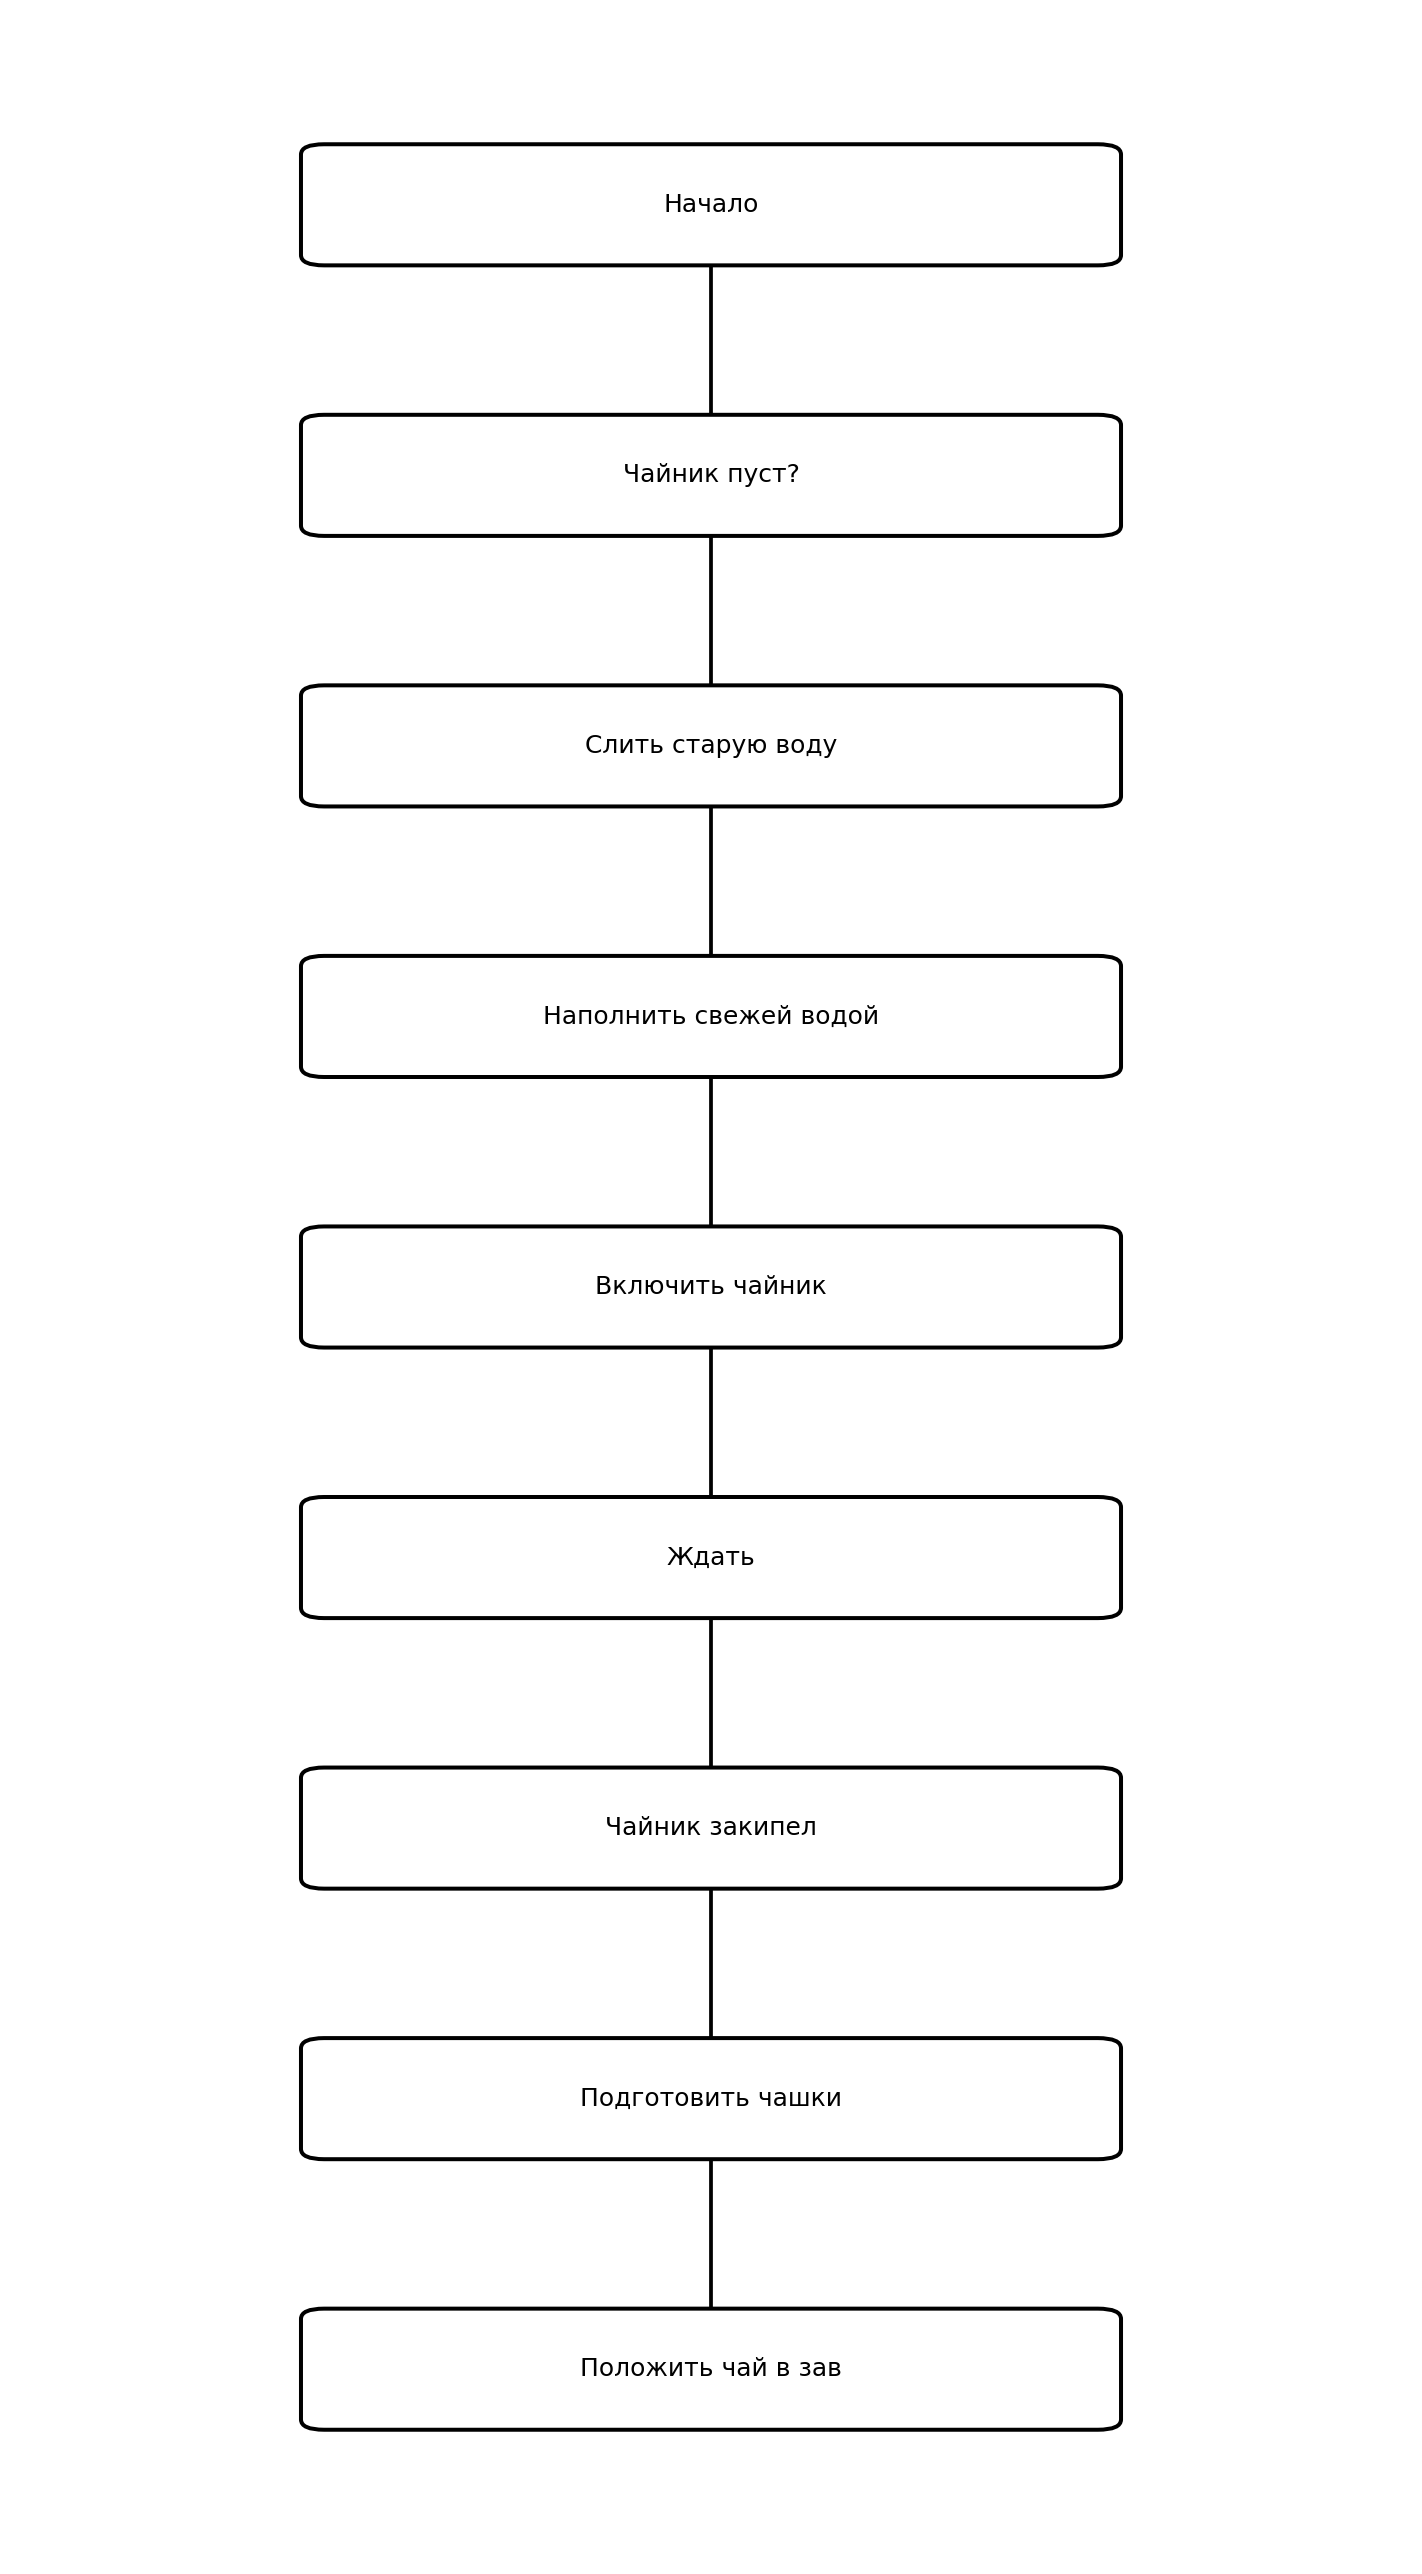

Saved: algo_diagram.png


In [32]:

algo_text = res['raw_text']
res1 = algorithm_text_to_diagram_png_no_llm(algo_text, out_png="algo_diagram.png")
print("Saved:", res1["png_path"])